In [1]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [41]:
# create sample data set
n1_samples = 150
n2_samples = 150
signal_dim = 10 

mean1 = np.ones(signal_dim)*0.05
cov1 = np.eye(signal_dim)*0.01
x1 = np.random.multivariate_normal(mean1, cov1, n1_samples)
y1 = np.zeros(n1_samples)

mean2 = np.ones(signal_dim)*-0.05
# mean2 = mean1
cov2 = np.eye(signal_dim)*0.01
x2 = np.random.multivariate_normal(mean2, cov2, n2_samples)
y2 = np.ones(n2_samples)

X = np.vstack([x1, x2]) # [n_samples, n_dims]
Y = np.append(y1, y2)   # [n_samples, _]
n_samples = n1_samples + n2_samples
X_dim = X.shape[1]

In [42]:
# add noise 
noise_dim = 10
n = np.random.multivariate_normal(np.zeros(noise_dim), np.eye(noise_dim), n_samples)
X = np.hstack([X,n])
# X.shape
X_dim = X.shape[1]

In [43]:
# standardize 
X = StandardScaler().fit_transform(X)

Text(0, 0.5, 'X2')

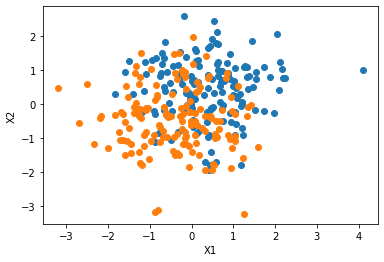

In [44]:
plt.scatter(X[:n1_samples,0], X[:n1_samples,1])
plt.scatter(X[n1_samples:,0], X[n1_samples:,1])
plt.xlabel("X1")
plt.ylabel("X2")

In [45]:
# Augment X (to drop the intercept)
def augment(x):
    n_samples = np.size(x, axis=0)
    x_aug = np.c_[x,np.ones(n_samples)]
    return x_aug 
X = augment(X)
X_dim = X.shape[1]
X.shape

(300, 21)

In [46]:
#define model
w_sd = 10
logistic_model = pm.Model()
with logistic_model:
#     w = pm.Normal('w', mu=0.0, sd=w_sd, shape=X_dim)
    w = pm.Laplace('w', mu=0.0, b=w_sd, shape=X_dim)
    logit_p = pm.Deterministic('p', 1. / (1. + tt.exp(-tt.dot(X, w))))
    
    # Create the bernoulli parameter which uses observed data to inform the algorithm
    observed = pm.Bernoulli('obs', logit_p, observed=Y)

In [47]:
# check model 
logistic_model.check_test_point()

w      -62.91
obs   -207.94
Name: Log-probability of test_point, dtype: float64

# MAP Estimate

In [48]:
# map estimate
map_estimate = pm.find_MAP(model=logistic_model)
w_hat = map_estimate['w']   # [n_dim, ]

In [49]:
print('MAP estimate of w: {}'.format(w_hat))

MAP estimate of w: [-1.09531701e+00 -1.64292406e+00 -8.71089970e-01 -8.94203726e-01
 -1.90044647e+00 -2.41053603e+00 -1.15969096e+00 -1.50818545e+00
 -1.30665651e+00 -1.49905815e+00 -6.03634627e-01  3.07032798e-01
 -5.66676093e-01  7.62079870e-01 -7.12883911e-10  5.59433147e-04
  1.05250723e-02  1.44296783e-01  8.06261981e-01 -1.48997382e-01
  3.42113729e-02]


In [50]:
def predict_proba_map(x, w_hat):
    # x, shape = [n_samples, ndim]
    # w_hat, shape = [n_dim,_]
    w_dot_x =  np.dot(x, w_hat)  
    logit_func = lambda z: 1./(1. + np.exp(-z))       # sig(z)
    prob = logit_func(w_dot_x)
    return prob

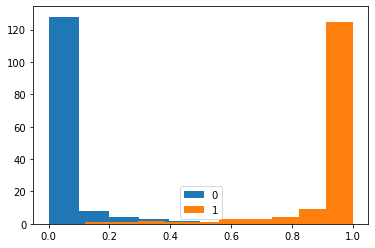

In [51]:
# compute probability - MAP 
y_prob_map = predict_proba_map(X, w_hat)
plt.hist(y_prob_map[Y==0])
plt.hist(y_prob_map[Y==1])
plt.legend(['0', '1'])

In [52]:
def plot_roc(y_true, y_prob, max_fpr=1):
    max_fpr=1
    fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
    plt.plot(fpr[fpr < max_fpr], tpr[fpr < max_fpr])
    plt.grid()
    plt.title("ROC")
    plt.xlabel('PFA')
    plt.ylabel('PD')

AUC: 0.9926666666666667


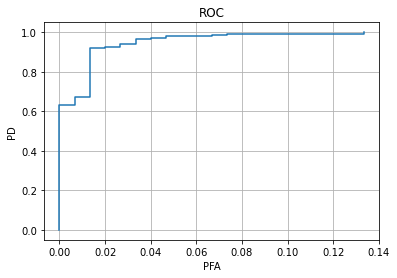

In [53]:
# Plot ROC
print('AUC: {}'.format(roc_auc_score(Y, y_prob_map)))
plot_roc(Y, y_prob_map)

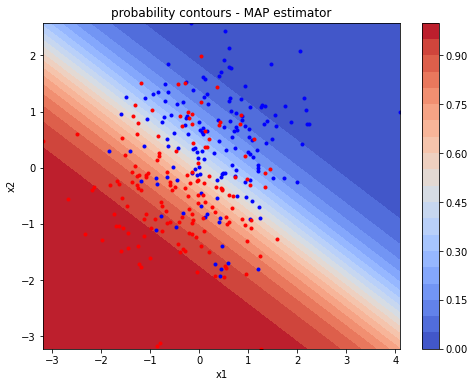

In [54]:
# create grid for heatmap
def plot_prob_contours_map(x, y, w_hat):
    n_grid = 500
    max_x      = np.max(x[:,:2],axis = 0)
    min_x      = np.min(x[:,:2],axis = 0)
    X1         = np.linspace(min_x[0],max_x[0],n_grid)
    X2         = np.linspace(min_x[1],max_x[1],n_grid)
    x1,x2      = np.meshgrid(X1,X2)
    Xgrid      = np.zeros([n_grid**2,2])
    Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
    Xgrid[:,1] = np.reshape(x2,(n_grid**2,))

    blr_grid = predict_proba_map(augment(Xgrid), np.append(w_hat[:2], w_hat[-1]))
    lev   = np.linspace(0,1,21)  
    plt.figure(figsize=(8,6))
    plt.contourf(X1,X2,np.reshape(blr_grid,(n_grid,n_grid)),
                 levels = lev,cmap=cm.coolwarm)
    plt.plot(x[y==0,0],x[y==0,1],"bo", markersize = 3)
    plt.plot(x[y==1,0],x[y==1,1],"ro", markersize = 3)
    plt.colorbar()
    plt.title('probability contours - MAP estimator')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()
    
plot_prob_contours_map(X, Y, w_hat)

# Laplace Approximation

In [55]:
# Compute the Hessian Matrtix
def compute_hessian(x, w_hat, sigma_w):
        w_dot_x =  np.matmul(x,w_hat)                        # W^T*X
        logit_func = lambda z: 1./(1. + np.exp(-z))       # sig(z)
        d_vec = (1-logit_func(w_dot_x))*logit_func(w_dot_x)  # [1-sig(z)]sig(z)=sig(-z)*sig(z)
        H = np.matmul(np.matmul(x.T,np.diag(d_vec)), x) + np.linalg.inv(sigma_w)
        return H
    
sigma_w = np.eye(X_dim)*np.square(w_sd)
H = compute_hessian(X, w_hat, sigma_w)

In [56]:
# Approximate the posterior (laplace)
lap_covw = np.linalg.inv(H)
lap_meanw = w_hat

In [57]:
# Compute predictive prob the Laplace approximation
def predict_proba_samp(x, w_samp):
    w_dot_x =  np.matmul(x, w_samp.T) 
    logit_func = lambda z: 1./(1. + np.exp(-z))       # sig(z)
    sample_prob = logit_func(w_dot_x)
    prob = np.mean(sample_prob, axis=1)
    return prob

(1000, 21)

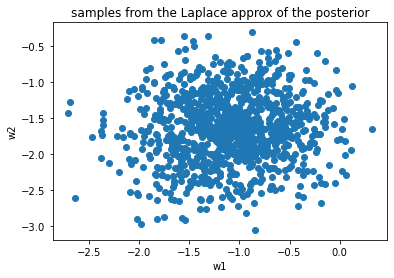

In [58]:
# Monte Carlo Sampling of the posterior 
n_mc_samples = 1000
w_samp_laplace = np.random.multivariate_normal(lap_meanw, lap_covw, n_mc_samples)  #[n_mc_samples, n_dim]

plt.scatter(w_samp_laplace[:,0], w_samp_laplace[:,1])
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('samples from the Laplace approx of the posterior')
w_samp_laplace.shape

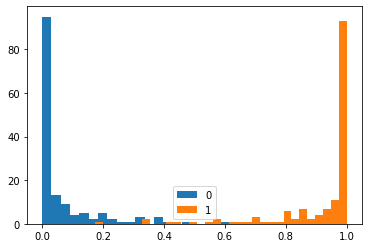

In [59]:
# compute probability - lap
y_prob_lap = predict_proba_samp(X, w_samp_laplace)
plt.hist(y_prob_lap[Y==0], bins=32)
plt.hist(y_prob_lap[Y==1], bins=32)
plt.legend(['0', '1'])

AUC: 0.9923111111111111


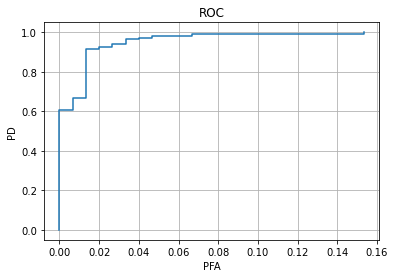

In [60]:
# Plot ROC
print('AUC: {}'.format(roc_auc_score(Y, y_prob_lap)))
plot_roc(Y, y_prob_lap)

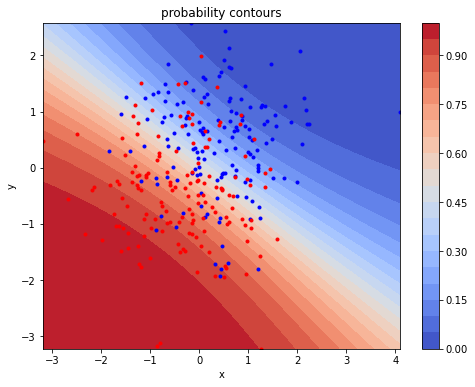

In [61]:
# create grid for heatmap
def plot_prob_contours_samp(x, y, w_samp):
    n_grid = 500
    max_x      = np.max(x[:,:2],axis = 0)
    min_x      = np.min(x[:,:2],axis = 0)
    X1         = np.linspace(min_x[0],max_x[0],n_grid)
    X2         = np.linspace(min_x[1],max_x[1],n_grid)
    x1,x2      = np.meshgrid(X1,X2)
    Xgrid      = np.zeros([n_grid**2,2])
    Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
    Xgrid[:,1] = np.reshape(x2,(n_grid**2,))
      
    blr_grid = predict_proba_samp(augment(Xgrid), w_samp[:,[0,1,-1]])
    
    lev   = np.linspace(0,1,21)  
    plt.figure(figsize=(8,6))
    plt.contourf(X1,X2,np.reshape(blr_grid,(n_grid,n_grid)),
                 levels = lev,cmap=cm.coolwarm)
    plt.plot(x[y==0,0],x[y==0,1],"bo", markersize = 3)
    plt.plot(x[y==1,0],x[y==1,1],"ro", markersize = 3)
    plt.colorbar()
    plt.title('probability contours')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
plot_prob_contours_samp(X, Y, w_samp_laplace)

# MCMC

In [62]:
# MCMC
with logistic_model:
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    trace = pm.sample(500, cores=4, init='adapt_diag')

/home/assaf/miniconda3/envs/bayesian-logistic-regression/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [63]:
# w_sample_post = trace.get_values('w', burn=500, combine=False)
w_sample_post = trace

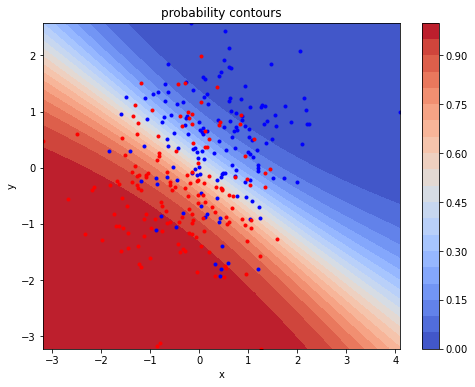

In [64]:
plot_prob_contours_samp(X, Y, trace.get_values('w')[::4])